In [137]:
import json
from src.data import DATA_DIR
from hazm import word_tokenize
from src.utils.io import read_file, read_tel_messages, remove_stopwords
from hazm import Normalizer, word_tokenize, sent_tokenize
from collections import Counter
import pickle
from collections import defaultdict
import seaborn as sns

In [4]:
stopwords = read_file(DATA_DIR/'persian_stop_words.txt').split('\n')

2022-03-21 18:45:06.798 | INFO     | src.utils.io:read_file:22 - Loding data from text...


In [5]:
with open(DATA_DIR / 'cs_stack.json') as fp:
    data = json.load(fp)

# 

# Detect Qustions

In [105]:
def get_text_from_tel_msg(tel_msg):
    if isinstance(tel_msg['text'], str):
        msg_ = tel_msg['text']
        
    else:
        msg_ = ""
        for sub_msg in tel_msg['text']:
            if isinstance(sub_msg, str):
                msg_ += " " + sub_msg
                
            elif 'text' in sub_msg:
                msg_ += " " + sub_msg['text']
    
    return msg_

In [148]:
def search_in_lines(text: str=None, text_path: str=None,search_val: list=None) -> list:
    """
    :param text: A text containig multi lines
    :param text_path: Path of a text containig multi lines
    :param search_val: If one of these values exist in setence, that sentece will be returned
    """
    sentences = []
    if text is not None:
        text_ = text
    
    elif text_path is not None:
        with open(text_path) as fp:
            text_ = fp.read()
            
    else:
        raise InputError

    textlines = sent_tokenize(text_)
    for sen in textlines:
        if (sum([i in sen for i in search_val]) > 0) and (len(sen) >= 3):
            sentences.append(sen)                
    return sentences

In [149]:
data_text = []
question_ids = defaultdict(bool)

for msg in data['messages']:
    msg_ = get_text_from_tel_msg(msg)
    
    msg_ = remove_stopwords(msg_, stopwords)
    if sum([i in msg_ for i in ['؟', '?']]) > 0:
        data_text.extend(search_in_lines(text=msg_, search_val=['؟', '?']))
        question_ids[msg['id']] = True

In [108]:
Tokens = word_tokenize(" ".join(data_text))
Counter(Tokens).most_common(10)

[('؟', 3097),
 ('سلام', 623),
 ('دوستان', 479),
 ('نصب', 423),
 ('،', 377),
 ('ببخشید', 193),
 ('کردم', 179),
 (')', 176),
 ('کلاس', 172),
 ('?', 169)]

In [109]:
question = list(filter(lambda text: ('?' in text) or ('؟' in text), data_text))
len(question)

3538

In [110]:
text_message = read_tel_messages(file_path=DATA_DIR / 'cs_stack.json', normalize=True)

2022-03-21 19:17:38.766 | INFO     | src.utils.io:read_json:12 - Loding data from json...
2022-03-21 19:17:38.909 | INFO     | src.utils.io:read_tel_messages:53 - Extracting chat messages from loaded data...


# 

# Train a Model

In [11]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

In [12]:
feature = read_file(DATA_DIR / 'feature.txt').split('\n')

2022-03-21 18:45:14.204 | INFO     | src.utils.io:read_file:22 - Loding data from text...


In [13]:
data_text_BOG = []
for text in text_message:
    list_ = [0] * len(feature)
    for ind, item in enumerate(feature):
        if item in text:
            list_[ind] = 1
    data_text_BOG.append(list_)

In [14]:
df = pd.DataFrame(data_text_BOG, columns=feature)
df.head()

,؟,دوستان,نصب,ببخشید,کلاس,?,ثبت,کار,مشکل,چی,...,دسترسی,مگه,رفع,سیستم,جلسات,نمیاد,لطفا,منظورتون,کمک,کنم
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(df)

In [16]:
clf = LogisticRegression(random_state=0).fit(data_text_BOG, kmeans.labels_)

In [17]:
clf.predict([data_text_BOG[2]])

array([0], dtype=int32)

In [18]:
file_path = DATA_DIR / 'finalized_model.sav'
pickle.dump(clf, open(file_path, 'wb'))

# 

# Replies Statistics

In [112]:
def Search_in_sent(text, search_val: list=None):
    return sum([i in text for i in search_val]) > 0

In [113]:
def get_text_from_tel_msg(tel_msg):
    if isinstance(tel_msg['text'], str):
        msg_ = tel_msg['text']
        
    else:
        msg_ = ""
        for sub_msg in tel_msg['text']:
            if isinstance(sub_msg, str):
                msg_ += " " + sub_msg
                
            elif 'text' in sub_msg:
                msg_ += " " + sub_msg['text']
    
    return msg_

In [114]:
message_ids = {}
for ind, msg in enumerate(data['messages']):
    message_ids[msg['id']] = ind

In [180]:
users = defaultdict(dict)
for msg in data['messages']:
    if not 'reply_to_message_id' in msg:
        continue
    
    if not msg['reply_to_message_id'] in message_ids:
        continue
        
    replied_msg_id = message_ids[msg['reply_to_message_id']]
    
    msg_ = get_text_from_tel_msg(data['messages'][replied_msg_id])
    if not Search_in_sent(msg_, search_val=['؟', '?']):
        continue
        
    users[msg['from_id']]['Name'] = f"{msg['from']}"
    
    if 'Replies' in users[msg['from_id']]:
        users[msg['from_id']]['Replies'] += [replied_msg_id]

    else:
        users[msg['from_id']]['Replies'] = [replied_msg_id]

In [181]:
# {users[i]['Name']:len(users[i]['Replies']) for i in users}

In [182]:
reply_stat = defaultdict(list)
for i in users:
    reply_stat[len(users[i]['Replies'])] += [users[i]['Name']]

In [183]:
Num = 8
top_users = []

for i in sorted(reply_stat, reverse=True):
    top_users += [(*reply_stat[i], i)]
    
    if len(top_users) >= Num:
        break
        
top_users = dict(top_users)

<AxesSubplot:>

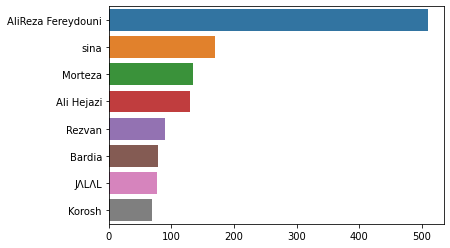

In [184]:
sns.barplot(y=list(top_users.keys()), x=list(top_users.values()))

In [185]:
import pandas as pd

In [199]:
a = pd.DataFrame((len(users[i]['Replies']) for i in users),
index=(users[i]['Name'] for i in users), columns=['a']).sort_values(0, ascending=False)

In [201]:
a.head()

,a
None,5
🇩🇪hwsyn.si🇩🇪,1
Ali Bayat Mokhtari,36
mhmd,1
Korosh,69


In [203]:
a = [i for i in range(100)]
a.head()

AttributeError: 'list' object has no attribute 'head'